In [327]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.backend import square, mean
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
import time

PLOT=True
# PLOT=False

SEQ_LEN=60
OUTPUT_LEN=30
EPOCHS=3
STEPS_PER_EPOCH=100
BATCH_SIZE=256
TARGET_VALUE="close"

In [328]:
url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
df.drop("volume", 1, inplace=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date', inplace=True)

df.head()

,open,high,low,close
date,,,,
2018-01-01 17:00:00,1.20037,1.20100,1.20037,1.20100
2018-01-01 17:01:00,1.20083,1.20095,1.20017,1.20030
2018-01-01 17:02:00,1.20035,1.20043,1.20035,1.20043
2018-01-01 17:03:00,1.20041,1.20050,1.20031,1.20046
2018-01-01 17:04:00,1.20049,1.20049,1.20046,1.20048


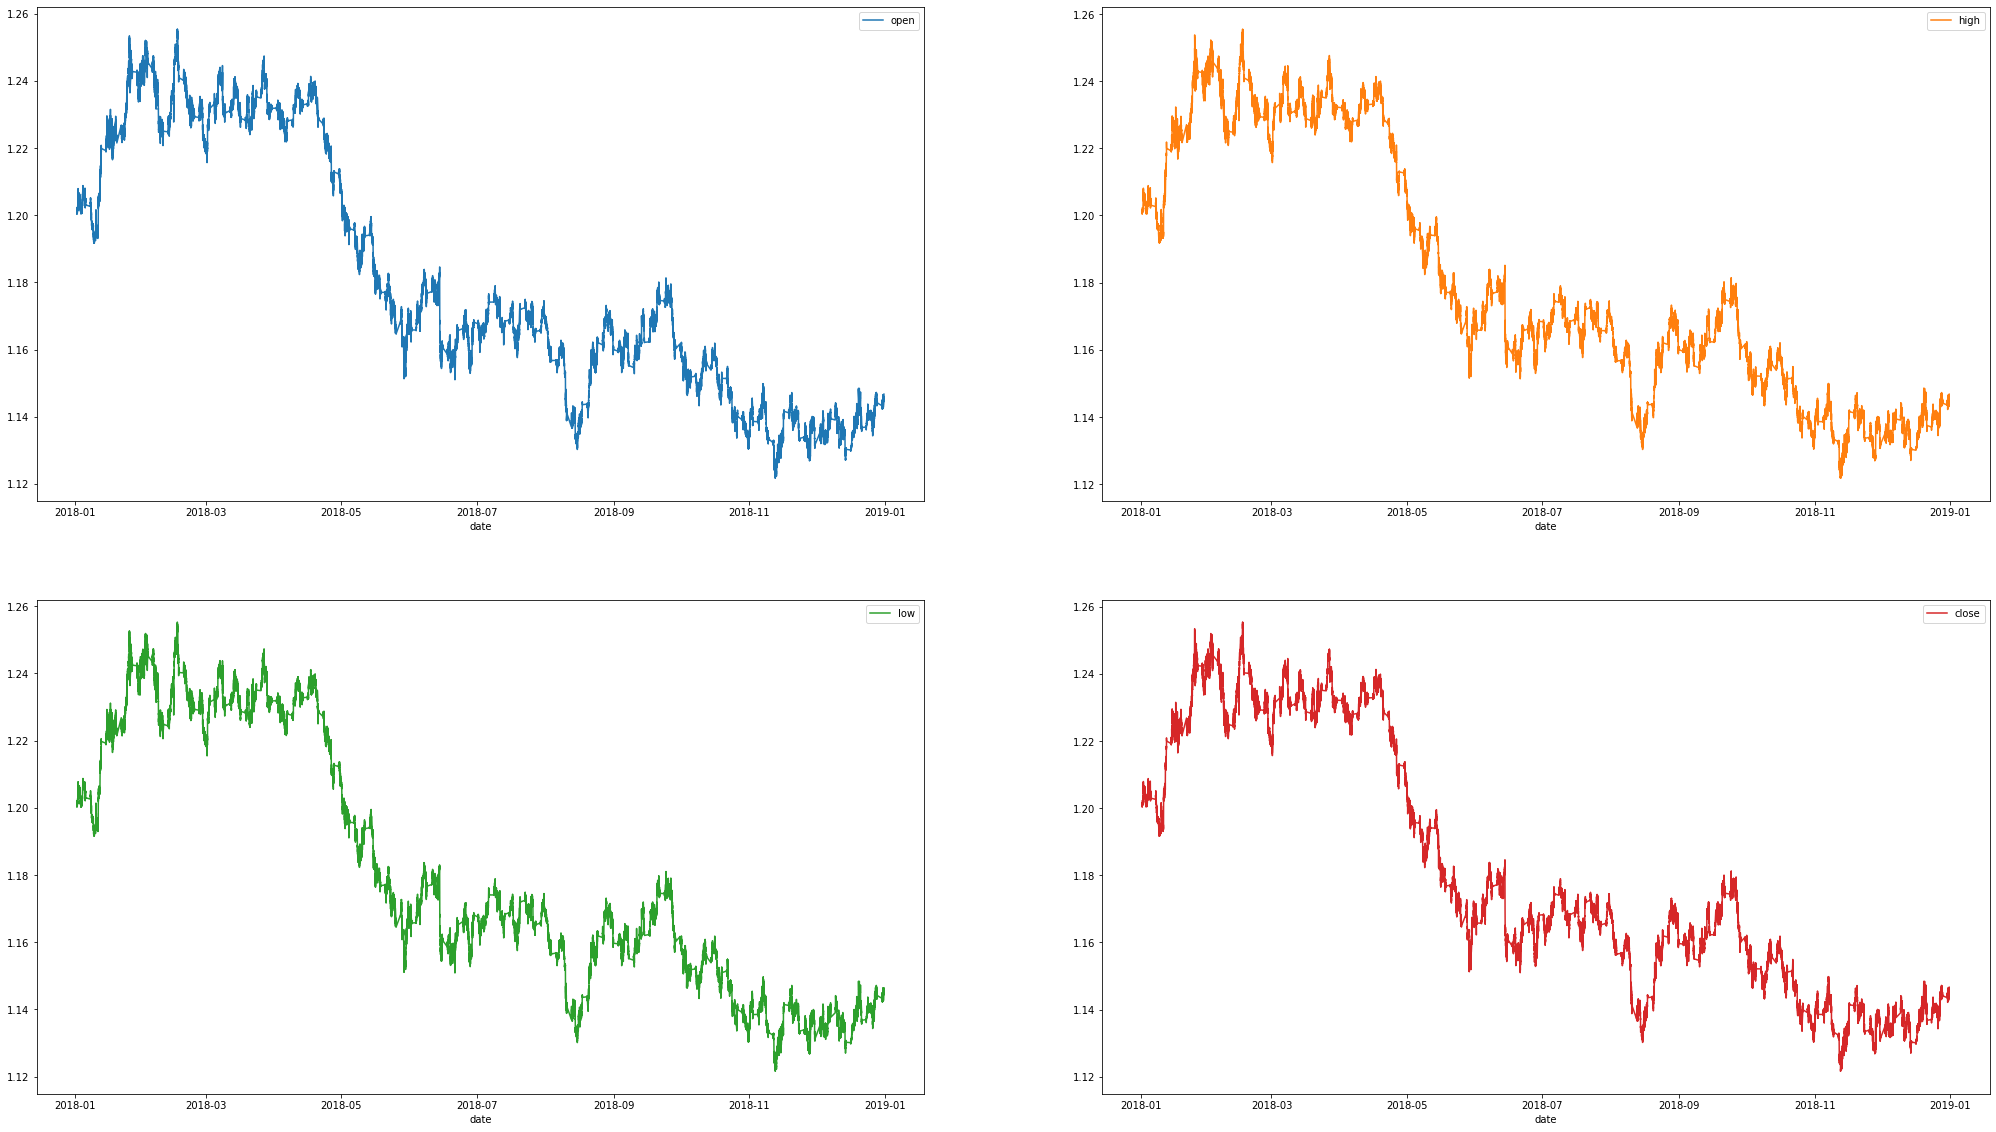

In [329]:
if PLOT:
    df.plot(subplots=True, layout=(2, 2), figsize=(35, 20), sharex=False)

In [330]:
df[TARGET_VALUE]

date
2018-01-01 17:00:00    1.20100
2018-01-01 17:01:00    1.20030
2018-01-01 17:02:00    1.20043
2018-01-01 17:03:00    1.20046
2018-01-01 17:04:00    1.20048
                        ...   
2018-12-31 16:55:00    1.14637
2018-12-31 16:56:00    1.14642
2018-12-31 16:57:00    1.14645
2018-12-31 16:58:00    1.14672
2018-12-31 16:59:00    1.14644
Name: close, Length: 372607, dtype: float64

In [331]:
shift_steps=OUTPUT_LEN
df_targets=df[TARGET_VALUE].shift(-shift_steps) # yeah, that minus there is realllyyyy important
print(df_targets)

date
2018-01-01 17:00:00        NaN
2018-01-01 17:01:00        NaN
2018-01-01 17:02:00        NaN
2018-01-01 17:03:00        NaN
2018-01-01 17:04:00        NaN
                        ...   
2018-12-31 16:55:00    1.14599
2018-12-31 16:56:00    1.14601
2018-12-31 16:57:00    1.14599
2018-12-31 16:58:00    1.14601
2018-12-31 16:59:00    1.14622
Name: close, Length: 372607, dtype: float64


In [332]:
# linewidth=0.5
# ax=df_targets.plot(figsize=(30,15), linewidth=linewidth)
# df[TARGET_VALUE].plot(ax=ax, linewidth=linewidth)

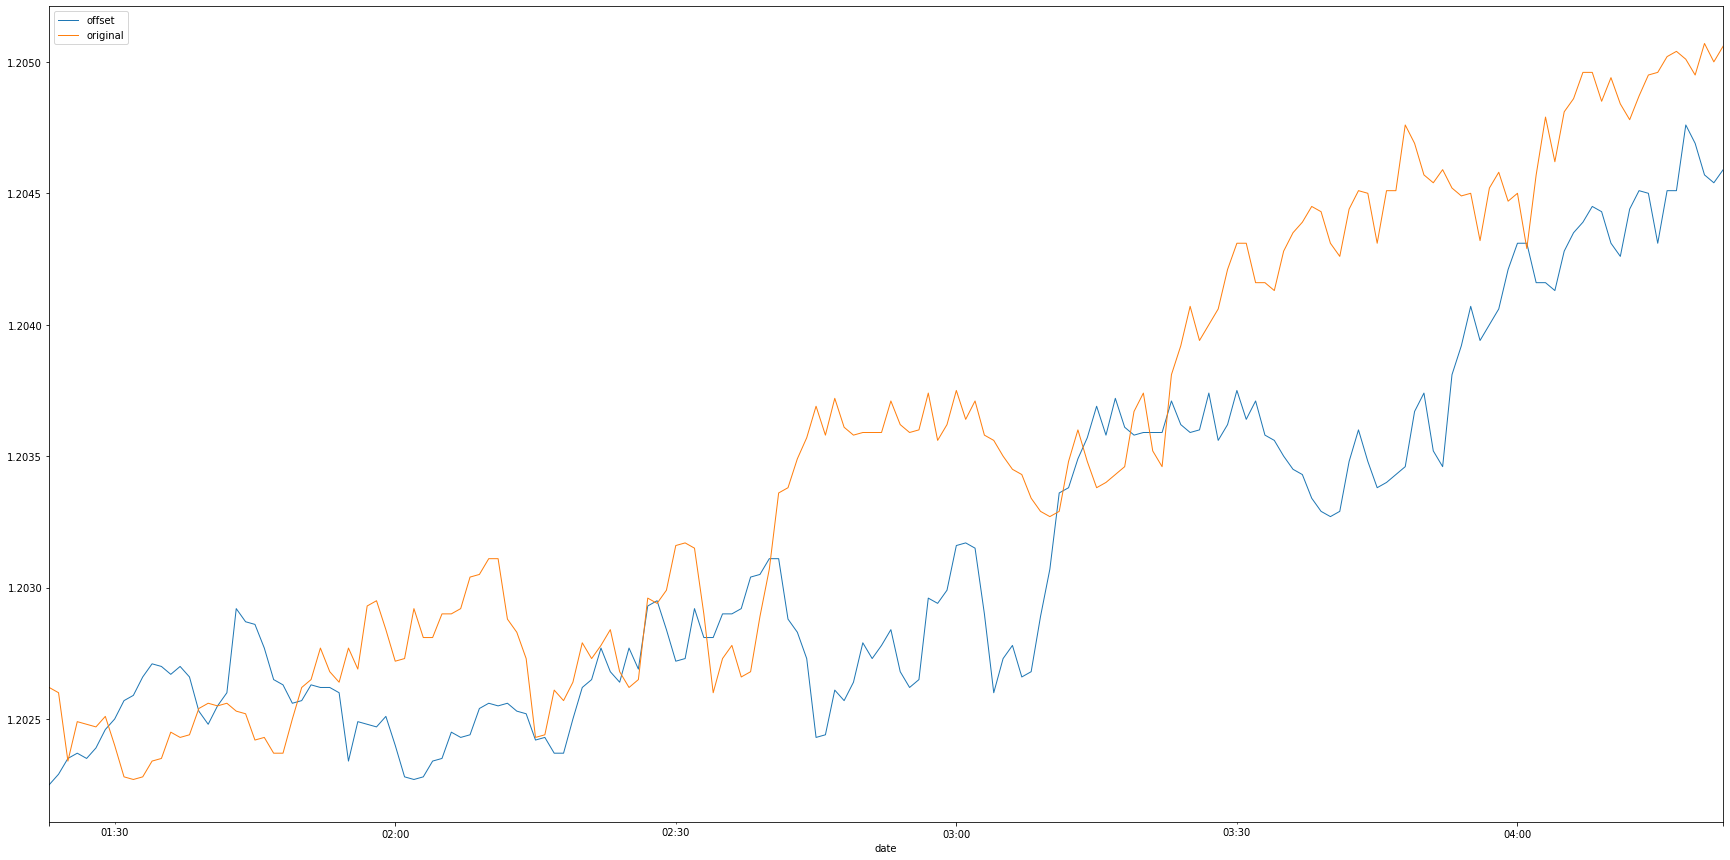

In [333]:
offset=500
linewidth=1
ax=df_targets[offset:offset+3*SEQ_LEN].plot(figsize=(30,15), linewidth=linewidth)
df[TARGET_VALUE][offset:offset+3*SEQ_LEN].plot(ax=ax, linewidth=linewidth)
ax.legend(["offset", "original"])

In [334]:
df_targets.tail(OUTPUT_LEN+3)

date
2018-12-31 16:27:00    1.14586
2018-12-31 16:28:00    1.14571
2018-12-31 16:29:00    1.14561
2018-12-31 16:30:00    1.14561
2018-12-31 16:31:00    1.14566
2018-12-31 16:32:00    1.14570
2018-12-31 16:33:00    1.14571
2018-12-31 16:34:00    1.14571
2018-12-31 16:35:00    1.14574
2018-12-31 16:36:00    1.14573
2018-12-31 16:37:00    1.14571
2018-12-31 16:38:00    1.14575
2018-12-31 16:39:00    1.14575
2018-12-31 16:40:00    1.14582
2018-12-31 16:41:00    1.14581
2018-12-31 16:42:00    1.14581
2018-12-31 16:43:00    1.14584
2018-12-31 16:44:00    1.14584
2018-12-31 16:45:00    1.14590
2018-12-31 16:46:00    1.14592
2018-12-31 16:47:00    1.14590
2018-12-31 16:48:00    1.14582
2018-12-31 16:49:00    1.14580
2018-12-31 16:50:00    1.14592
2018-12-31 16:51:00    1.14601
2018-12-31 16:52:00    1.14600
2018-12-31 16:53:00    1.14600
2018-12-31 16:54:00    1.14599
2018-12-31 16:55:00    1.14599
2018-12-31 16:56:00    1.14601
2018-12-31 16:57:00    1.14599
2018-12-31 16:58:00    1.14601
201

In [335]:
x_data=df[TARGET_VALUE].values[0:-shift_steps]
print(type(x_data))
print("shape:", x_data.shape)

<class 'numpy.ndarray'>
shape: (372577,)


In [336]:
y_data=df_targets.values[0:-shift_steps]
print(type(y_data))
print("shape:", y_data.shape)

<class 'numpy.ndarray'>
shape: (372577,)


In [337]:
train_split = 0.9

In [338]:
num_data = len(x_data)

In [339]:
num_train = int(train_split * num_data)
num_train

335319

In [340]:
num_test = num_data - num_train
num_test

37258

In [341]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

372577

In [342]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

372577

In [343]:
num_x_signals = x_data.shape[1] if len(x_data.shape)>1 else 1
num_x_signals

1

In [344]:
num_y_signals = y_data.shape[1] if len(y_data.shape)>1 else 1
num_y_signals

1

In [345]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 1.12163
Max: 1.2554100000000001


In [346]:
x_scaler = MinMaxScaler()
x_train_reshaped = x_train.reshape(-1,1)
x_train_scaled = x_scaler.fit_transform(x_train_reshaped)

In [347]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [348]:
x_test_reshaped=x_test.reshape(-1,1)
x_test_scaled = x_scaler.transform(x_test_reshaped)

In [349]:
y_scaler = MinMaxScaler()
y_train_reshaped = y_train.reshape(-1,1)
y_test_reshaped = y_test.reshape(-1,1)
y_train_scaled = y_scaler.fit_transform(y_train_reshaped)
y_test_scaled = y_scaler.transform(y_test_reshaped)

In [350]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(335319, 1)
(335319, 1)


In [351]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [352]:
sequence_length = 60 * 12 * 1
sequence_length

720

In [353]:
generator = batch_generator(batch_size=BATCH_SIZE,
                            sequence_length=sequence_length)

In [354]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 720, 1)
(256, 720, 1)


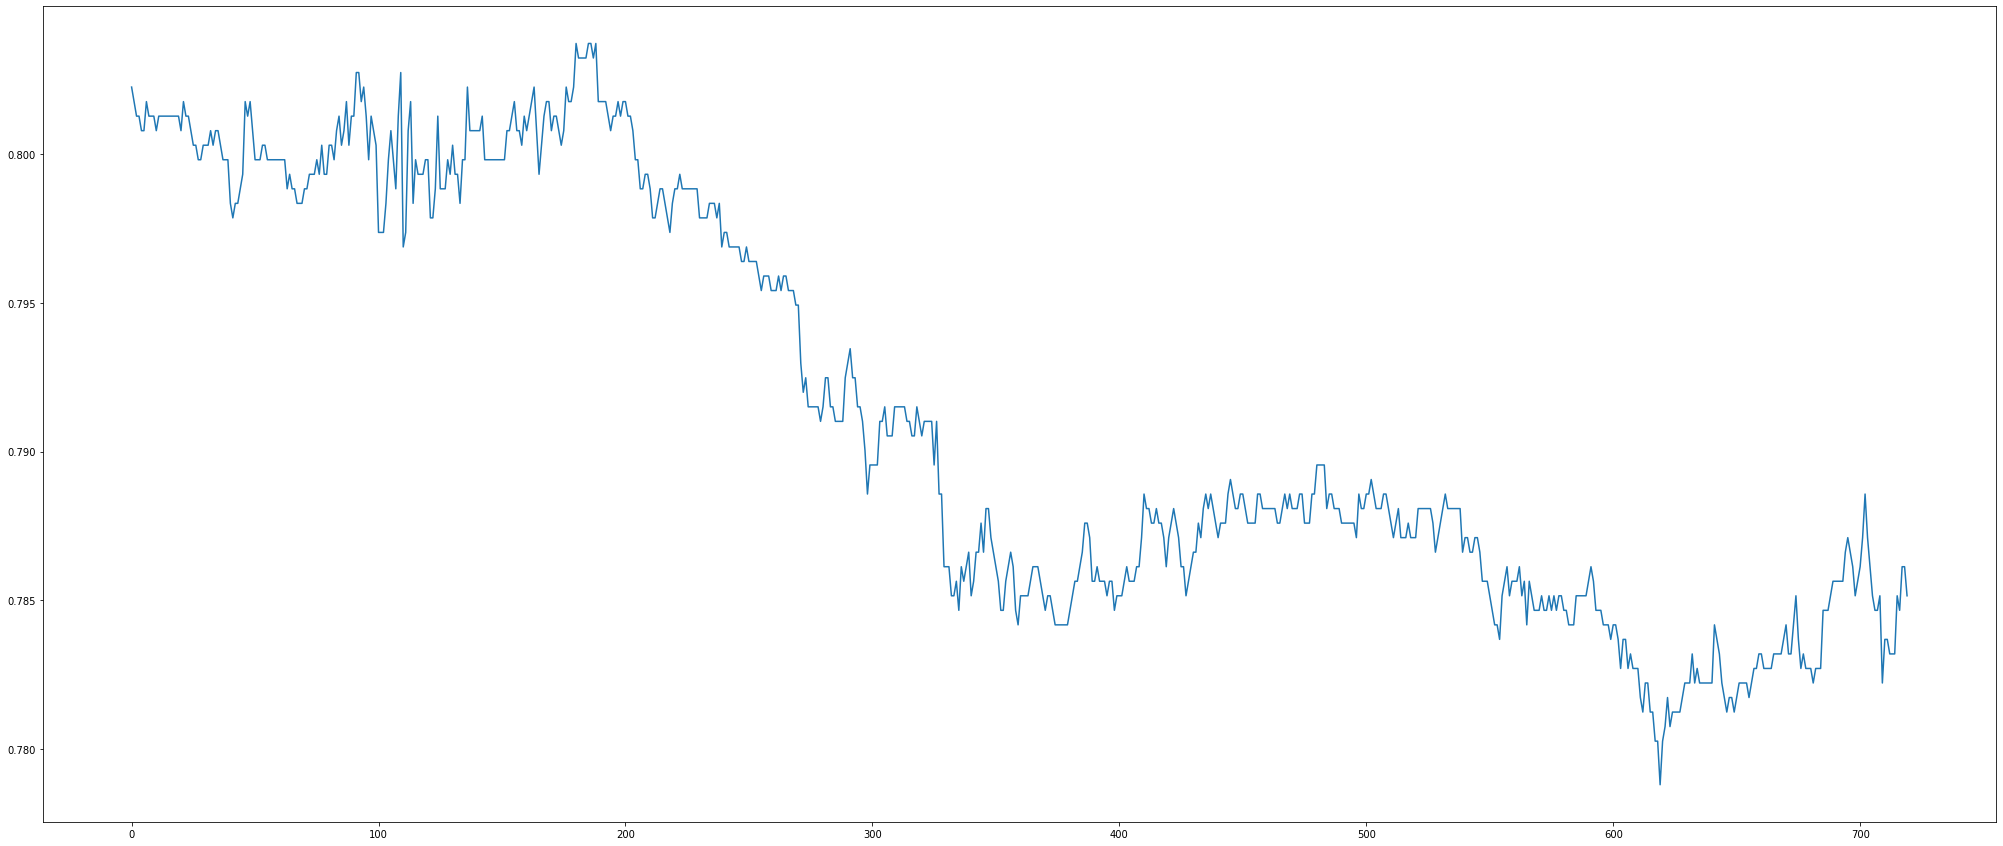

In [355]:
batch = 0  
signal = 0
seq = x_batch[batch, :, signal]
_, axes = plt.subplots(figsize=(35,15))
axes.plot(seq)

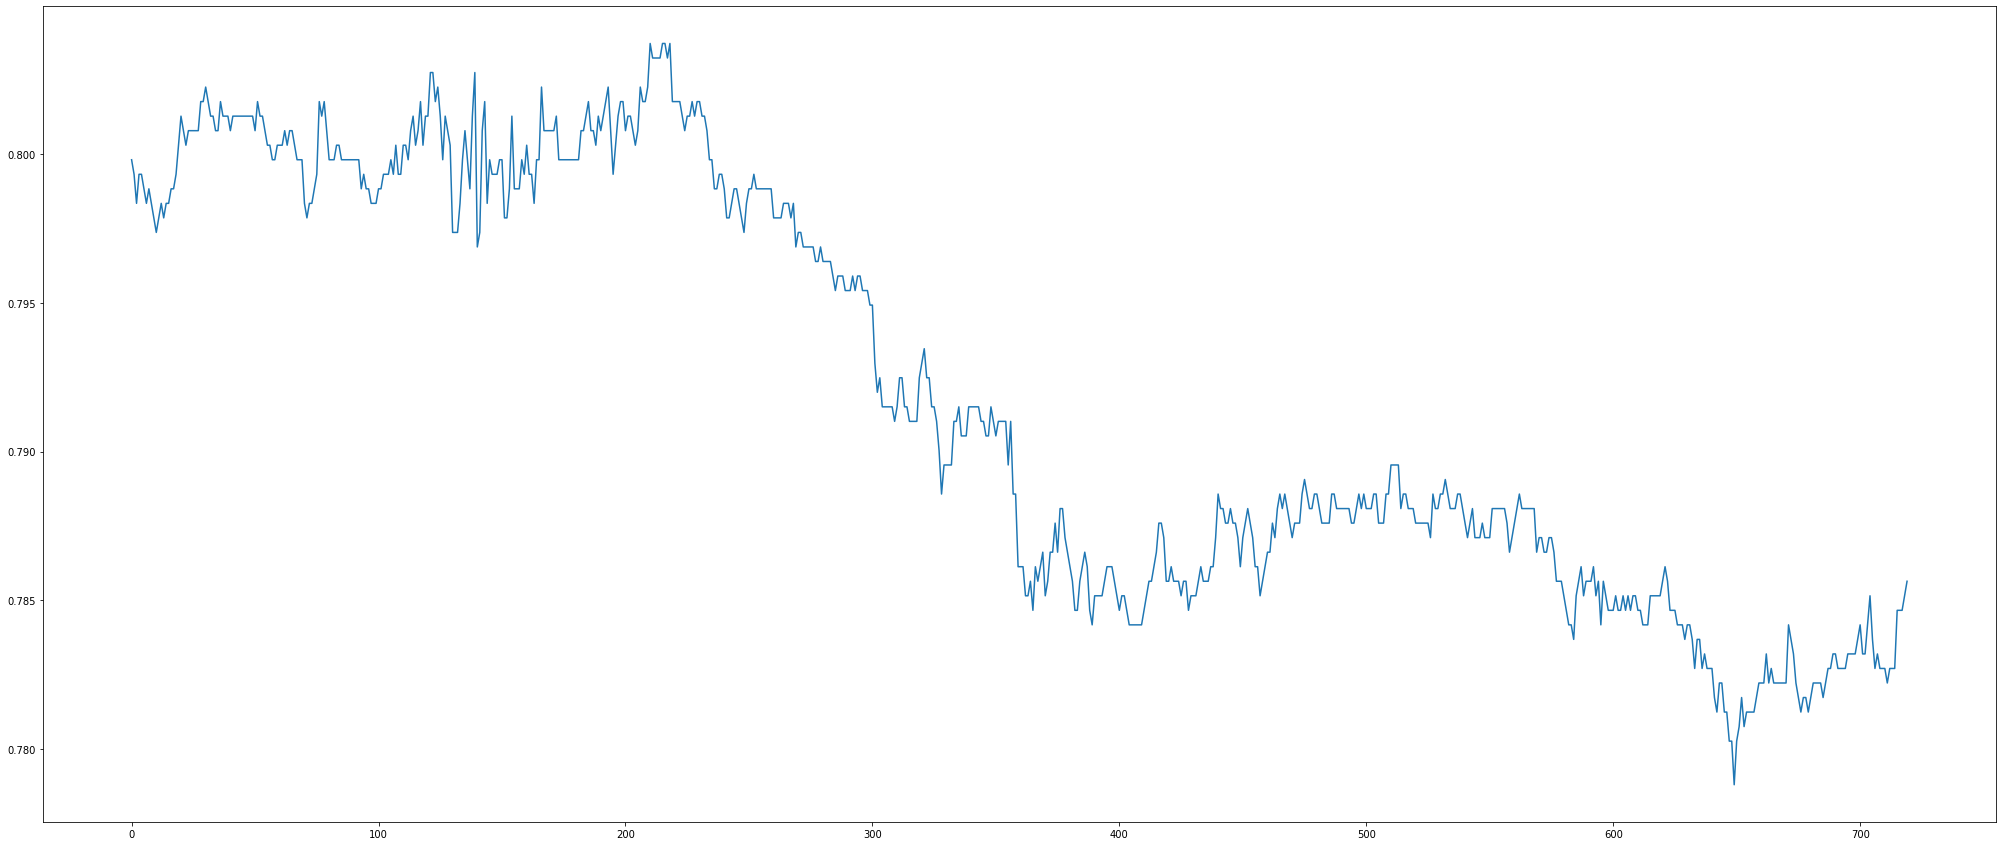

In [356]:
seq = y_batch[batch, :, signal]
_, axes = plt.subplots(figsize=(35,15))
axes.plot(seq)

In [357]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

In [358]:
model = Sequential()
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))
# model.add(Dense(num_y_signals, activation='sigmoid'))


init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(num_y_signals, activation='linear', kernel_initializer=init))

In [359]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [360]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

In [361]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, None, 512)         791040    
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           513       
Total params: 791,553
Trainable params: 791,553
Non-trainable params: 0
_________________________________________________________________


In [362]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)                           
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=1,
                                       verbose=1) 
callbacks = [callback_early_stopping,
             callback_reduce_lr]                                                                   

In [363]:
%%time
model.fit(x=generator,
          epochs=EPOCHS,
          steps_per_epoch=STEPS_PER_EPOCH,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/3
100/100 [==============================] - 494s 5s/step - loss: 0.0546 - val_loss: 0.0038 - lr: 0.0010
Epoch 2/3
100/100 [==============================] - 543s 5s/step - loss: 0.0055 - val_loss: 0.0023 - lr: 0.0010
Epoch 3/3
100/100 [==============================] - 509s 5s/step - loss: 0.0028 - val_loss: 1.1015e-04 - lr: 0.0010
CPU times: user 3h 43min 33s, sys: 18min 41s, total: 4h 2min 15s
Wall time: 26min


In [364]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 890us/step - loss: 1.1015e-04


In [365]:
print("loss (test-set):", result)

loss (test-set): 0.00011015323980245739


In [366]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # Get the output-signal predicted by the model.
    signal_pred = y_pred_rescaled.reshape(1,-1)[0]
    
    # Get the true output-signal from the data-set.
    signal_true = y_true.reshape(1,-1)[0]
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
    
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    
    # Plot grey box for warmup-period.
    p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    
    # Plot labels etc.
    plt.ylabel(TARGET_VALUE)
    plt.legend()
    plt.show()

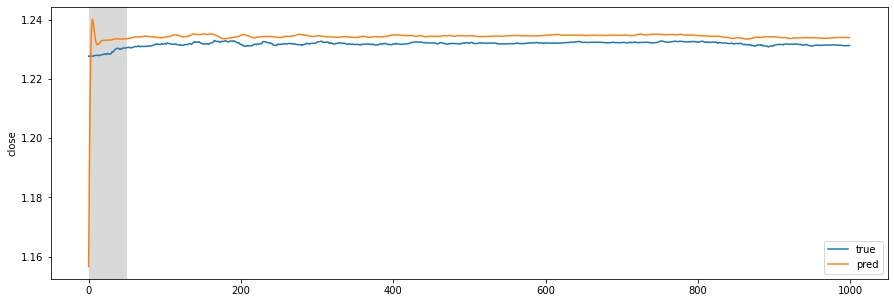

In [367]:
plot_comparison(start_idx=100000, length=1000, train=True)

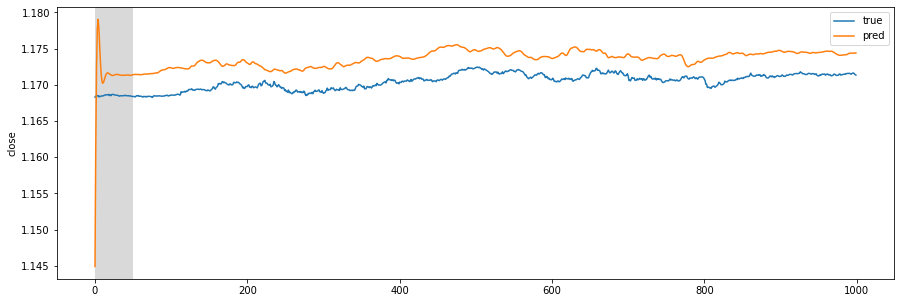

In [368]:
plot_comparison(start_idx=200000, length=1000, train=True)

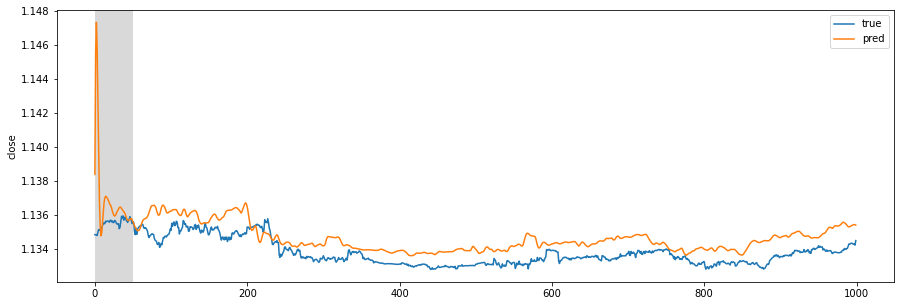

In [369]:
plot_comparison(start_idx=200, length=1000, train=False)